<img src="header.png" align="left"/>

# Exercise: Reinforcement Learning PPO Moon Lander (10 points)


The goal of this exercise is to work with reinforcement learning models and get a basic understanding of the topic. We will first develop controlers for the simple cart pole model and later for the lunar lander.
Neil Armstrong was the first to control a lunar lander in 1969. See a [video](https://youtu.be/xc1SzgGhMKc?t=520) about this masterpiece.
Luckily, we do not have to go to the moon, but can do our experiments in simulation based on the [Openai gym](https://gym.openai.com/) software.



https://uploads-ssl.webflow.com/5ca243f8aa6259298225af48/5d6603835e626f68cf2623c8_Lunar%20Lander%20Project%20Report.pdf


**Note**: if openai gym does not install in anaconda, please install gym in your conda environment using the following commands:

```
pip install gym
pip install box2d-py
```

**Note**: it can happend that the rendering window does not show up or close properly. In this case please check your environment and look for a solution and post it in the forum.


# Module imports

In [1]:
#
# Turn off errors and warnings (does not work sometimes)
#
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

#
# Import modules
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import random
import time

from collections import deque


In [2]:
#
# Some print options for numpy
#
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [3]:
#
# Tensorflow
#
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import scipy.signal



tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )


#
# Check version
#
print('starting notebook with tensorflow version {}'.format(tf.version.VERSION))

starting notebook with tensorflow version 2.4.1


# PPO Controller 


<div class="alert alert-block alert-info">

## Task

Now lets build a first version based on advanced RL technique, the proximal policy optimization (PPO) strategy. 
    
??http://arxiv.org/abs/1509.06461

    
The code is based on the work by Greg Surma and it can be found [here](https://github.com/gsurma/cartpole).


...

</div>

In [35]:

prefix = './04_ppo_'

# sources:
# https://keras.io/examples/rl/ppo_cartpole/


# Hyperparameters of the PPO algorithm
STEPSPEREPOCH = 4000
CLIPRATIO = 0.2
POLICYLEARNINGRATE = 3e-4
VALUEFUNCTIONLEARNINGRATE = 1e-3
TRAINPOLICYITERATIONS = 80
TRAINVALUEITERATIONS = 80
LAM = 0.97
TARGETKL = 0.01

EPOCHS = 30
GAMMA = 0.99


def discounted_cumulative_sums(x, discount):
    # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Buffer:
    # Buffer for storing trajectories
    def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
        # Buffer initialization
        self.size = size
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros(size, dtype=np.int32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        if self.pointer >= self.size:
            return
        
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1

    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        )
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )

    
   
class PPOControl:
    
    def __init__(self, observation_space, action_space, hidden_sizes = (64, 64), name='nona'):
        
        print ('building PPO model with observation space {} and action space {} layer {} name {}'.format(observation_space, action_space,hidden_sizes,name) )
        self.observation_dimensions = observation_space
        self.num_actions = action_space

        # Initialize the buffer
        self.buffer = Buffer(self.observation_dimensions, STEPSPEREPOCH)

        # Initialize the actor and the critic as keras models
        observation_input = keras.Input(shape=(self.observation_dimensions,), dtype=tf.float32)
        logits = self.mlp(observation_input, list(hidden_sizes) + [self.num_actions], tf.tanh, None)
        self.actor = keras.Model(inputs=observation_input, outputs=logits)
        
        value = tf.squeeze( self.mlp(observation_input, list(hidden_sizes) + [1], tf.tanh, None), axis=1 )
        self.critic = keras.Model(inputs=observation_input, outputs=value)

        # Initialize the policy and the value function optimizers
        self.policy_optimizer = keras.optimizers.Adam(learning_rate=POLICYLEARNINGRATE)
        self.value_optimizer = keras.optimizers.Adam(learning_rate=VALUEFUNCTIONLEARNINGRATE)

        # Initialize the observation, episode return and episode length
        self.observation, self.episode_return, self.episode_length = env.reset(), 0, 0    
    
    
    
    
    def mlp(self,x, sizes, activation=tf.tanh, output_activation=None):
        # Build a feedforward neural network
        for size in sizes[:-1]:
            x = layers.Dense(units=size, activation=activation)(x)
        return layers.Dense(units=sizes[-1], activation=output_activation)(x)


    def logprobabilities(self,logits, a):
        # Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
        logprobabilities_all = tf.nn.log_softmax(logits)
        logprobability = tf.reduce_sum(
            tf.one_hot(a, self.num_actions) * logprobabilities_all, axis=1
        )
        return logprobability


    # Sample action from actor
    @tf.function
    def sample_action(self,observation):
        logits = self.actor(observation)
        action = tf.squeeze( tf.random.categorical(logits, 1), axis=1 )
        return logits, action

    
    def action(self,observation):
        logits, action = self.sample_action(observation)
        return action[0].numpy()
    

    # Train the policy by maxizing the PPO-Clip objective
    @tf.function
    def train_policy(self,observation_buffer, action_buffer, logprobability_buffer, advantage_buffer):

        with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
            ratio = tf.exp(
                self.logprobabilities(self.actor(observation_buffer), action_buffer) - logprobability_buffer
            )
            min_advantage = tf.where(
                advantage_buffer > 0,
                (1 + CLIPRATIO) * advantage_buffer,
                (1 - CLIPRATIO) * advantage_buffer,
            )

            policy_loss = -tf.reduce_mean(
                tf.minimum(ratio * advantage_buffer, min_advantage)
            )
        policy_grads = tape.gradient(policy_loss, self.actor.trainable_variables)
        self.policy_optimizer.apply_gradients(zip(policy_grads, self.actor.trainable_variables))

        kl = tf.reduce_mean(
            logprobability_buffer
            - self.logprobabilities(self.actor(observation_buffer), action_buffer)
        )
        kl = tf.reduce_sum(kl)
        return kl


    # Train the value function by regression on mean-squared error
    @tf.function
    def train_value_function(self,observation_buffer, return_buffer):
        with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
            value_loss = tf.reduce_mean((return_buffer - self.critic(observation_buffer)) ** 2)
        value_grads = tape.gradient(value_loss, self.critic.trainable_variables)
        self.value_optimizer.apply_gradients(zip(value_grads, self.critic.trainable_variables))
    
        

In [36]:
def trainPPO(env,hidden_sizes = (64, 64), termination_runs=None, termination_runs_reward=None, name='nona', show_env = False ):
    
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    
    controller = PPOControl(observation_space, action_space, hidden_sizes = hidden_sizes, name=name)
    
    history = []
    experiments = 0
    
    # iterate over the number of epochs
    for epoch in range(EPOCHS):
        # Initialize the sum of the returns, lengths and number of episodes for each epoch
        sum_return = 0
        sum_length = 0
        num_episodes = 0
        controller.episode_length = 0
        
        # Iterate over the steps of each epoch
        for t in range(STEPSPEREPOCH):
            if show_env:
                env.render()

            # Get the logits, action, and take one step in the environment
            observation = controller.observation.reshape(1, -1)
            logits, action = controller.sample_action(observation)
            observation_new, reward, done, _ = env.step(action[0].numpy())
            
            controller.episode_length += 1
            
            if termination_runs and controller.episode_length > termination_runs:
                reward = termination_runs_reward
                done = True
            
            controller.episode_return += reward

            # Get the value and log-probability of the action
            value_t = controller.critic(observation)
            logprobability_t = controller.logprobabilities(logits, action)

            # Store obs, act, rew, v_t, logp_pi_t
            controller.buffer.store(observation, action, reward, value_t, logprobability_t)

            # Update the observation
            controller.observation = observation_new

            # Finish trajectory if reached to a terminal state
            terminal = done
            
            #if terminal or (t == STEPSPEREPOCH - 1) or ( termination_runs and controller.episode_length > termination_runs):
            if terminal or ( termination_runs and controller.episode_length > termination_runs):
                last_value = 0 if done else controller.critic(observation.reshape(1, -1))
                controller.buffer.finish_trajectory(last_value)
                sum_return += controller.episode_return
                sum_length += controller.episode_length
                num_episodes += 1
                
                print( 'episode: {}. return: {:.3f}. length: {}           '.format(num_episodes + 1, controller.episode_return, controller.episode_length), end="\r")
                
                controller.observation, controller.episode_return, controller.episode_length = env.reset(), 0, 0

        if num_episodes < 1:
            continue
                
                
                
        # Get values from the buffer
        (
            observation_buffer,
            action_buffer,
            advantage_buffer,
            return_buffer,
            logprobability_buffer,
        ) = controller.buffer.get()

        # update the policy and implement early stopping using KL divergence
        for _ in range(TRAINPOLICYITERATIONS):
            kl = controller.train_policy(
                observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
            )
            if kl > 1.5 * TARGETKL:
                # Early Stopping
                break

        # update the value function
        for _ in range(TRAINVALUEITERATIONS):
            controller.train_value_function(observation_buffer, return_buffer)

        # Print mean return and length for each epoch
        print( '\r', 'epoch: {}. return: {:.3f}. length: {}'.format(epoch + 1, sum_return / num_episodes, sum_length / num_episodes ))
        
        history.append([epoch,sum_return / num_episodes,sum_length / num_episodes])
        
        controller.observation, controller.episode_return, controller.episode_length = env.reset(), 0, 0

    env.close()
    return controller,history

# Cartpole Example

In [86]:
#
# Create new environment
#
env = gym.make("CartPole-v1")

In [ ]:
#
# Train model using trainDQN function
#
control,history = trainPPO(env=env,name='cartdqn')

In [90]:
#
# Create dataframe from history
#
df = pd.DataFrame(history,columns=['epoch','mean_return','episode_length'])

<AxesSubplot:>

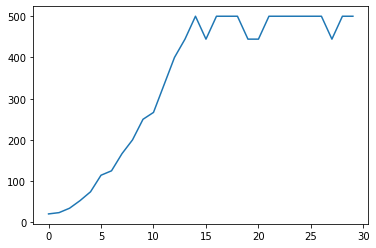

In [91]:
df['mean_return'].plot()

<AxesSubplot:>

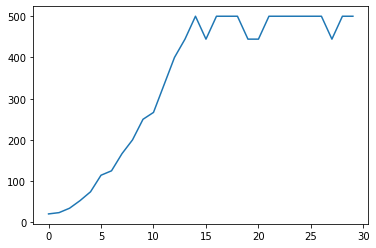

In [92]:
df['episode_length'].plot()

In [22]:
#
# Save model for later
#
control.save()

saved model to disk as results/04_dqn_cartdqnmodel.json results/04_dqn_cartdqnmodel.h5


In [11]:
#
# Test the DQL control
#

In [12]:
env = gym.make('CartPole-v1')

env.reset()

observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

control = DQNControl(observation_space, action_space, name='cartdqn')
control.load()

state = env.reset()
cumulated_reward = 0
restart_count = 0
longest_run = 0
cycle_count = 0

for i in range(100):
    
    env.render(mode='close')

    # get the next action from the controler
    action = control.action( np.reshape(state, [1, observation_space] ) )
    
    # apply action to environment
    observation, reward, done, _ = env.step( action )
    
    # check status
    cumulated_reward += reward
    cycle_count += 1
    state = observation
        
    print( '\r', 'position:{:.2f} pole angle:{:.2f} reward:{} cumulated reward:{} d:{}   a:{}    '.format(observation[2],observation[0],reward,cumulated_reward,done, action), end='' )
    
    if done:
        state = env.reset()
        cumulated_reward = 0
        longest_run = max(longest_run,cycle_count)
        cycle_count = 0
        restart_count += 1

    # some delay important for display to catch up
    time.sleep(0.05)
      
env.close()

print( '\nlongest run {} with {} restarts'.format( longest_run, restart_count) )

building DQN model with observation space 4 and action space 2 layer [24, 24] name cartdqn
loaded model from disk file results/04_dqn_cartdqnmodel.json results/04_dqn_cartdqnmodel.h5
 position:-0.13 pole angle:-0.94 reward:1.0 cumulated reward:100.0 d:False   a:1    
longest run 0 with 0 restarts


# Lunar lander problem

How we are looking into the lunar lander problem. We reuse the DQN controller from above with different parameters. Configuration is taken from [2,3]. A general discussion about this approach was published in [1].

- [1] https://www.researchgate.net/publication/333145451_Deep_Q-Learning_on_Lunar_Lander_Game
- [2] https://towardsdatascience.com/ai-learning-to-land-a-rocket-reinforcement-learning-84d61f97d055
- [3] https://medium.datadriveninvestor.com/training-the-lunar-lander-agent-with-deep-q-learning-and-its-variants-2f7ba63e822c

In [29]:
#
# Create new environment for lunar lander
#
#env = gym.make('LunarLander-v2')

from gym.envs.registration import register

register(
    id='LunarLanderFuel-v1',
    entry_point='lunar_lander_fuel:LunarLanderFuel'
)

env = gym.make('LunarLanderFuel-v1')



In [37]:
#
# Update some hyperparameters
#
# Hyperparameters of the PPO algorithm
STEPSPEREPOCH = 800
EPOCHS = 100
GAMMA = 0.98
POLICYLEARNINGRATE = 3e-4
VALUEFUNCTIONLEARNINGRATE = 1e-3
TRAINPOLICYITERATIONS = 80
TRAINVALUEITERATIONS = 80


In [38]:
#
# Train controller
#
control,history = trainPPO(env=env,hidden_sizes = (128, 64, 32), name='lunar', show_env=True )

building PPO model with observation space 9 and action space 4 layer (128, 64, 32) name lunar
 epoch: 1. return: -260.605. length: 93.0           
 epoch: 2. return: -110.068. length: 87.33333333333333
 epoch: 3. return: -126.256. length: 80.55555555555556
 epoch: 4. return: -93.147. length: 87.005           
 epoch: 5. return: -66.542. length: 74.4           
 epoch: 6. return: -68.072. length: 71.2            
 epoch: 7. return: -77.931. length: 84.013           
 epoch: 8. return: -64.051. length: 86.22222222222223
 epoch: 9. return: -96.114. length: 93.50           
 epoch: 10. return: -90.046. length: 95.0           
 epoch: 11. return: -34.221. length: 110.71428571428571
 epoch: 12. return: -74.709. length: 96.125        
 epoch: 13. return: -104.118. length: 92.375       
 epoch: 14. return: -37.741. length: 96.71428571428571
 epoch: 15. return: -68.681. length: 96.0          
 epoch: 16. return: -84.606. length: 113.14285714285714
 epoch: 17. return: -61.670. length: 111.5     

In [39]:
#
# Create dataframe from history
#
df = pd.DataFrame(history,columns=['epoch','mean_return','episode_length'])

<AxesSubplot:>

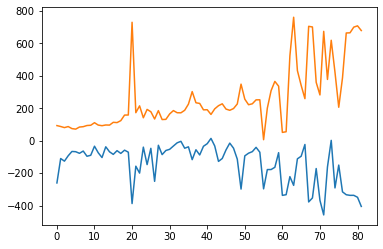

In [40]:
df['mean_return'].plot()
df['episode_length'].plot()

# Testing Lunar Lander

In [54]:
env.reset()
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

#control = DQNControl(observation_space, action_space, name='lunar')
#control.load()

state = env.reset()
cumulated_reward = 0
restart_count = 0
longest_run = 0
cycle_count = 0

while True:
    
    env.render(mode='close')

    # get the next action from the controler
    action = control.action( np.reshape(state, [1, observation_space] ) )
    
    # apply action to environment
    observation, reward, done, _ = env.step( action )
    
    # check status
    cumulated_reward += reward
    cycle_count += 1
    state = observation
        
    if done:
        state = env.reset()
        cumulated_reward = 0
        cycle_count = 0
        print( 'round {} with cumulated reward:{}    '.format(restart_count,cumulated_reward), end='' )
        restart_count += 1
                
    # some delay important for display to catch up
    time.sleep(0.05)
      
env.close()

round 0 with cumulated reward:0    round 1 with cumulated reward:0    round 2 with cumulated reward:0    

KeyboardInterrupt: 

In [55]:
# Save model for later
control.save()

AttributeError: 'PPOControl' object has no attribute 'save'